In [463]:
# Add table of contents

# Libraries and Notebook Options

In [931]:
import pandas as pd
import numpy as np
from sodapy import Socrata

from collections import Counter

# Exploratory Data Analysis
from pandas_profiling import ProfileReport

# Modeling
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC, SVC # Remove
from sklearn.datasets import make_classification

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix

# Visualizations
from matplotlib.pyplot import figure
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
%matplotlib inline


In [408]:
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

def start():
    options = {
        'display': {
            'max_columns': None,
            'max_colwidth': -1,
            'expand_frame_repr': False,  # Don't wrap to multiple pages
            'max_rows': 10,
            'max_seq_items': 25,         # Max length of printed sequence
            'precision': 5,
            'show_dimensions': False
        },
        'mode': {
            'chained_assignment': None   # Controls SettingWithCopyWarning
        }
    }

    for category, option in options.items():
        for op, value in option.items():
            pd.set_option(f'{category}.{op}', value)  # Python 3.6+

if __name__ == '__main__':
    start()

del start  # Clean up namespace in the interpreter

# SODA API

In [53]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata('data.sfgov.org', None)

# Authenticate the client
domain = 'data.sfgov.org'
app_token = 'tZuHs7ko1xQezRBAgUN10D0i9'
username = 'corraljrmiguel@gmail.com'
password = 'Xd9@rzwPhZjKsNg8cima'

client = Socrata(domain,
                 app_token,
                 username=username,
                 password=password)

# Returns as JSON from API
# converted to Python list of dictionaries by sodapy.
results = client.get('vw6y-z8j6', limit=10000)
# results = client.get('vw6y-z8j6', where='service_request_id=12167455')

# Convert to pandas dataframe
df = pd.DataFrame.from_records(results)

In [491]:
# # Pickle dataframe
# df.to_pickle('data/df_raw_10k.pkl')

# Load dataframe
df = pd.read_pickle('data/df_raw_10k.pkl')

In [60]:
df.shape

(10000, 47)

# Data Cleaning

In [869]:
# Import CSV – 4.1M rows
df = pd.read_csv('data/311_Cases.csv', nrows=10000)

# Sort dataframe by CaseID (newest first)
df.sort_values(by='CaseID', ascending=False, inplace=True)

# Reset the index
df.reset_index(drop=True, inplace=True)

In [870]:
# Drop all undocumented columns
df = df.iloc[:, 0:19]
# df = df.loc[:, ~df.columns.str.contains('^:@')]

df.shape

(10000, 19)

In [871]:
df.head()

,CaseID,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,Address,Street,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Point,Source
0,12145810,02/27/2020 02:57:00 PM,02/27/2020 03:40:00 PM,02/27/2020 03:40:00 PM,Closed,"Case Resolved - Maribel Jaldon ""I Emailed Customer.""",County Clerk - G,General Request - COUNTY CLERK,request_for_service,county_clerk - request_for_service,Not associated with a specific address,NaN,NaN,NaN,NaN,0.00000,0.00000,"(0.0, 0.0)",Phone
1,12145806,02/27/2020 02:56:00 PM,NaN,02/27/2020 03:46:52 PM,Open,sent,Duplicate Case Hold Queue,Street and Sidewalk Cleaning,Human or Animal Waste,Human or Animal Waste,"1400 17TH ST, SAN FRANCISCO, CA, 94107",17TH ST,10.0,Potrero Hill,SOUTHERN,37.76535,-122.39787,"(37.76535231, -122.39786653)",Web
2,12145798,02/27/2020 02:56:26 PM,02/28/2020 07:30:11 AM,02/28/2020 07:30:11 AM,Closed,Case is a Duplicate,DPW BSSR Queue,Street Defects,Pavement_Defect,Pavement_Defect,Intersection of 33RD AVE and PACHECO ST,33RD AVE,4.0,Outer Sunset,TARAVAL,37.74985,-122.49121,"(37.74984741, -122.49121094)",Integrated Agency
3,12145586,02/27/2020 02:21:00 PM,02/27/2020 04:03:57 PM,02/27/2020 04:03:57 PM,Closed,Case Resolved - Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Furniture,Intersection of TURK ST and LAGUNA ST,TURK ST,5.0,Cathedral Hill,NORTHERN,37.78112,-122.42720,"(37.78111649, -122.42720032)",Phone
4,12145581,02/27/2020 02:20:00 PM,NaN,02/27/2020 02:45:03 PM,Open,open,MUNI Work Queue,MUNI Feedback,MUNI - Services_Service_Delivery_Facilities,611_Signs_Maps_and_Auto_Announcements,Intersection of 3RD ST and PALOU AVE,3RD ST,10.0,Bayview,BAYVIEW,37.73401,-122.39097,"(37.7340126, -122.39096832)",Phone


In [872]:
# Strip column names and format
df.columns = df.columns.str.strip().str.lower().str.replace(
    ' ', '_').str.replace('(', '').str.replace(')', '')

# Rename 'caseid' column
df.rename({'caseid': 'case_id'}, axis='columns', inplace=True)

In [873]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
case_id                10000 non-null int64
opened                 10000 non-null object
closed                 9272 non-null object
updated                10000 non-null object
status                 10000 non-null object
status_notes           9893 non-null object
responsible_agency     10000 non-null object
category               10000 non-null object
request_type           10000 non-null object
request_details        9878 non-null object
address                10000 non-null object
street                 9466 non-null object
supervisor_district    9466 non-null float64
neighborhood           9465 non-null object
police_district        9461 non-null object
latitude               10000 non-null float64
longitude              10000 non-null float64
point                  10000 non-null object
source                 10000 non-null object
dtypes: float64(3), int64(1), object(15)
m

In [874]:
# Convert time columns to datetime
df['opened'] = pd.to_datetime(df['opened'])
df['closed'] = pd.to_datetime(df['closed'])
df['updated'] = pd.to_datetime(df['updated'])
# df.iloc[:, 1:4] = pd.to_datetime(df.iloc[:, 1:4].stack()).unstack()

In [875]:
df.shape

(10000, 19)

In [876]:
# Remove incomplete years (2008 & 2020)
df = df.loc[(df['opened'] >= '2009-01-01') & (df['opened'] <= '2019-12-31')]

# Drop all rows with any missing value
df.dropna(how='any', inplace=True)

# Drop 'status' column as all incidents are 'closed' after running the code above
df.drop('status', axis=1, inplace=True)

df.shape

(2238, 18)

In [877]:
# Convert categorical columns to 'category' type
df['supervisor_district'] = pd.to_numeric(df['supervisor_district'], downcast='integer').astype('category')

cols = df[['category', 'neighborhood', 'police_district', 'source']]
for col in cols:
    df[col] = df[col].astype('category')
    
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2238 entries, 7182 to 9999
Data columns (total 18 columns):
case_id                2238 non-null int64
opened                 2238 non-null datetime64[ns]
closed                 2238 non-null datetime64[ns]
updated                2238 non-null datetime64[ns]
status_notes           2238 non-null object
responsible_agency     2238 non-null object
category               2238 non-null category
request_type           2238 non-null object
request_details        2238 non-null object
address                2238 non-null object
street                 2238 non-null object
supervisor_district    2238 non-null category
neighborhood           2238 non-null category
police_district        2238 non-null category
latitude               2238 non-null float64
longitude              2238 non-null float64
point                  2238 non-null object
source                 2238 non-null category
dtypes: category(5), datetime64[ns](3), float64(2), int64(1), o

In [878]:
# Create is_duplicate column
def create_is_duplicate(df):
    """Create 'is_duplicate' column"""
    
    # Search for 'duplicate' in status_notes
    df['is_duplicate'] = df['status_notes'].str.lower().str.contains('duplicate')
    
    # Fill 'nan' values with False
    df['is_duplicate'].fillna(False, inplace=True)
    
    return df

create_is_duplicate(df)
df.head(5)

,case_id,opened,closed,updated,status_notes,responsible_agency,category,request_type,request_details,address,street,supervisor_district,neighborhood,police_district,latitude,longitude,point,source,is_duplicate
7182,11879660,2019-12-30 23:38:00,2020-01-04 14:12:01,2020-01-04 14:12:01,Case Transferred - Should be routed to 311 Call Center,DPW Ops Queue,Tree Maintenance,Trees - Overgrown_Tree,Pruning_request,"43 CHENERY ST, SAN FRANCISCO, CA, 94131",CHENERY ST,8,Fairmount,INGLESIDE,37.74109,-122.42565,"(37.74109, -122.42565)",Mobile/Open311,False
7183,11879654,2019-12-30 23:36:00,2019-12-31 14:06:24,2019-12-31 14:06:24,Case Resolved - SES Graffiti Crew - Scrape - Pole - Sign (Comment),DPW Ops Queue,Illegal Postings,Illegal Postings - Affixed_Improperly,Affixed Improperly,"5828 GEARY BLVD, SAN FRANCISCO, CA, 94121",GEARY BLVD,1,Outer Richmond,RICHMOND,37.78036,-122.48195,"(37.78036333, -122.481955)",Mobile/Open311,False
7184,11879642,2019-12-30 23:30:00,2020-01-03 10:14:44,2020-01-03 10:14:44,Encampment Removed,HSOC Queue,General Request - PUBLIC WORKS,request_for_service,bsm - request_for_service,"49 ISIS ST, SAN FRANCISCO, CA, 94103",ISIS ST,6,South of Market,SOUTHERN,37.77003,-122.41459,"(37.77003037, -122.41458782)",Web,False
7185,11879593,2019-12-30 22:48:00,2020-01-03 09:54:29,2020-01-03 09:54:29,Encampment Removed,Duplicate Case Hold Queue,Encampments,Encampment Reports,Encampment Cleanup,"3515 16TH ST, SAN FRANCISCO, CA, 94114",16TH ST,8,Castro,MISSION,37.76424,-122.43125,"(37.7642427, -122.43125)",Web,False
7186,11879571,2019-12-30 22:19:33,2020-01-03 00:00:00,2020-01-03 00:00:00,Case Resolved - Abated Tags,DPW Ops Queue,Graffiti,Graffiti on Fire_Police_Callbox,Fire_Police_Callbox - Not_Offensive,Intersection of POST ST and TAYLOR ST,POST ST,3,Lower Nob Hill,CENTRAL,37.78789,-122.41171,"(37.78788736, -122.41170562)",Mobile/Open311,False


In [879]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df, title='Pandas Profiling Report', html={'style':{'full_width':True}})
# profile.to_notebook_iframe()

## Balancing Data

In [880]:
# Target variable
target_count = df['is_duplicate'].value_counts()

# Print class balance
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')

Class 0: 2096
Class 1: 142
Proportion: 14.76 : 1
Percentage of Majority Class: 93.66


# Pre-Processing

In [881]:
df.head(1)

,case_id,opened,closed,updated,status_notes,responsible_agency,category,request_type,request_details,address,street,supervisor_district,neighborhood,police_district,latitude,longitude,point,source,is_duplicate
7182,11879660,2019-12-30 23:38:00,2020-01-04 14:12:01,2020-01-04 14:12:01,Case Transferred - Should be routed to 311 Call Center,DPW Ops Queue,Tree Maintenance,Trees - Overgrown_Tree,Pruning_request,"43 CHENERY ST, SAN FRANCISCO, CA, 94131",CHENERY ST,8,Fairmount,INGLESIDE,37.74109,-122.42565,"(37.74109, -122.42565)",Mobile/Open311,False


In [882]:
# Columns to exclude
filter_cols = [
    'case_id',
    'opened', # Needs Feature Eng
    'closed', # Needs Feature Eng
    'updated',
    'responsible_agency', # Needs NLP
    'status_notes', # Needs NLP
    'request_type', # Needs NLP
    'request_details', # Needs NLP
    'address', # Needs NLP
    'point',
    'is_duplicate' # Target variable
]

# Instantiate independent variables including dummies
x_variables_df = df.drop(columns=filter_cols, axis=0, inplace=False)
X = pd.get_dummies(x_variables_df, drop_first=True)

# Target variable
y = df['is_duplicate']

# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020, stratify=y)

In [885]:
print('df', df.shape)
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)

df (2238, 19)
X_train (1790, 795)
X_test (448, 795)
y_train (1790,)
y_test (448,)


## SMOTE

In [932]:
# NOT SURE IF I NEED THIS
# Generate synthetic imbalanced data 
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=1, 
                           weights=[0.04, 0.96],
                           class_sep=0.2, random_state=42)

In [933]:
X_smoted, y_smoted = SMOTE(random_state=2020).fit_sample(X, y)
Counter(y_smoted)

Counter({1: 4777, 0: 4777})

In [934]:
xgbc_smote = XGBClassifier().fit(X_smoted, y_smoted) # X_train, y_train

In [ ]:
# Doesn't work
plot_decision_regions(X_smoted, y_smoted, xgbc_smote)
plt.title(f'SMOTE XGBosst with y = {Counter(y_smoted)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.gcf().set_size_inches(12,8)

In [935]:
y_pred = xgbc_smote.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {round(accuracy, 4)*100}')

ValueError: feature_names mismatch: ['f0', 'f1'] ['latitude', 'longitude', 'category_Abandoned Vehicle', 'category_Blocked Street or SideWalk', 'category_Catch Basin Maintenance', 'category_Damaged Property', 'category_Encampments', 'category_General Request - ANIMAL CARE CONTROL', 'category_General Request - ASSESSOR RECORDER', 'category_General Request - DPH', 'category_General Request - FIRE DEPARTMENT', 'category_General Request - MTA', 'category_General Request - PUBLIC WORKS', 'category_General Request - PUC', 'category_General Request - RPD', 'category_Graffiti', 'category_Illegal Postings', 'category_MUNI Feedback', 'category_Noise Report', 'category_Parking Enforcement', 'category_Rec and Park Requests', 'category_Residential Building Request', 'category_SFHA Requests', 'category_Sewer Issues', 'category_Sidewalk or Curb', 'category_Sign Repair', 'category_Street Defects', 'category_Street and Sidewalk Cleaning', 'category_Streetlights', 'category_Tree Maintenance', 'street_11TH AVE', 'street_11TH ST', 'street_12TH AVE', 'street_12TH ST', 'street_13TH ST', 'street_14TH AVE', 'street_14TH ST', 'street_15TH AVE', 'street_15TH ST', 'street_16TH AVE', 'street_16TH ST', 'street_17TH AVE', 'street_17TH ST', 'street_18TH AVE', 'street_18TH ST', 'street_19TH AVE', 'street_19TH ST', 'street_1ST ST', 'street_20TH AVE', 'street_20TH ST', 'street_21ST AVE', 'street_21ST ST', 'street_22ND AVE', 'street_22ND ST', 'street_23RD AVE', 'street_23RD ST', 'street_24TH AVE', 'street_24TH ST', 'street_25TH AVE', 'street_25TH ST', 'street_26TH AVE', 'street_26TH ST', 'street_27TH AVE', 'street_28TH AVE', 'street_29TH AVE', 'street_29TH ST', 'street_2ND AVE', 'street_2ND ST', 'street_30TH AVE', 'street_30TH ST', 'street_31ST AVE', 'street_33RD AVE', 'street_34TH AVE', 'street_35TH AVE', 'street_36TH AVE', 'street_37TH AVE', 'street_38TH AVE', 'street_39TH AVE', 'street_3RD AVE', 'street_3RD ST', 'street_40TH AVE', 'street_42ND AVE', 'street_43RD AVE', 'street_44TH AVE', 'street_45TH AVE', 'street_46TH AVE', 'street_47TH AVE', 'street_48TH AVE', 'street_4TH AVE', 'street_4TH ST', 'street_5TH AVE', 'street_5TH ST', 'street_6TH AVE', 'street_6TH ST', 'street_7TH AVE', 'street_7TH ST', 'street_8TH AVE', 'street_8TH ST', 'street_9TH AVE', 'street_9TH ST', 'street_ADA CT', 'street_ADDISON ST', 'street_ALABAMA ST', 'street_ALAMEDA ST', 'street_ALBION ST', 'street_ALEMANY BLVD', 'street_ALPHA ST', 'street_ALVARADO ST', 'street_ALVISO ST', 'street_ANDOVER ST', 'street_ANGLO ALY', 'street_ANZA ST', 'street_ARCH ST', 'street_ARELIOUS WALKER DR', 'street_ARGENT ALY', 'street_ARGUELLO BLVD', 'street_ARKANSAS ST', 'street_ASHBURY ST', 'street_AUGUSTA ST', 'street_AUSTIN ST', 'street_AVALON AVE', 'street_Alamo Square', 'street_Alioto Mini Park', 'street_BACON ST', 'street_BAKER ST', 'street_BALBOA ST', 'street_BANKS ST', 'street_BARNEVELD AVE', 'street_BARTLETT ST', 'street_BATTERY ST', 'street_BAY SHORE BLVD', 'street_BAY ST', 'street_BEACH ST', 'street_BEALE ST', 'street_BEAUMONT AVE', 'street_BEAVER ST', 'street_BELCHER ST', 'street_BELLA VISTA WAY', 'street_BELVEDERE ST', 'street_BERKELEY WAY', 'street_BERKSHIRE WAY', 'street_BERNAL HEIGHTS BLVD', 'street_BERNICE ST', 'street_BERRY ST', 'street_BEVERLY ST', 'street_BIRCH ST', 'street_BLUXOME ST', 'street_BOCANA ST', 'street_BONITA ST', 'street_BONVIEW ST', 'street_BOSWORTH ST', 'street_BOWDOIN ST', 'street_BOWMAN CT', 'street_BRADY ST', 'street_BRANNAN ST', 'street_BRAZIL AVE', 'street_BRENTWOOD AVE', 'street_BREWSTER ST', 'street_BRIDGEVIEW DR', 'street_BRIGHT ST', 'street_BROAD ST', 'street_BROADWAY', 'street_BROOKDALE AVE', 'street_BROTHERHOOD WAY', 'street_BRUNSWICK ST', 'street_BRUSSELS ST', 'street_BRYANT ST', 'street_BUCHANAN ST', 'street_BUENA VISTA AVE EAST', 'street_BURROWS ST', 'street_BUSH ST', 'street_BYXBEE ST', 'street_Buena Vista Park', 'street_CABRILLO ST', 'street_CALEDONIA ST', 'street_CALIFORNIA ST', 'street_CAMBRIDGE ST', 'street_CAMP ST', 'street_CAPITOL AVE', 'street_CAPP ST', 'street_CARGO WAY', 'street_CARL ST', 'street_CARMEL ST', 'street_CAROLINA ST', 'street_CARROLL AVE', 'street_CASTLE MANOR AVE', 'street_CASTRO ST', 'street_CAYUGA AVE', 'street_CEDAR ST', 'street_CENTRAL AVE', 'street_CERVANTES BLVD', 'street_CESAR CHAVEZ ST', 'street_CHANNEL ST', 'street_CHATTANOOGA ST', 'street_CHENERY ST', 'street_CHESTNUT ST', 'street_CHICAGO WAY', 'street_CHRISTOPHER DR', 'street_CHURCH ST', 'street_CIRCULAR AVE', 'street_CLAY ST', 'street_CLAYTON ST', 'street_CLEMENT ST', 'street_CLEMENTINA ST', 'street_CLIFFORD TER', 'street_CLIPPER ST', 'street_COLE ST', 'street_COLERIDGE ST', 'street_COLLEGE AVE', 'street_COLLINGWOOD ST', 'street_COLON AVE', 'street_COLUMBUS AVE', 'street_COMMERCIAL ST', 'street_CONNECTICUT ST', 'street_CONVERSE ST', 'street_CORA ST', 'street_CORBETT AVE', 'street_CORDOVA ST', 'street_CORTLAND AVE', 'street_CRESCENT AVE', 'street_CRESTA VISTA DR', 'street_CUMBERLAND ST', 'street_CUVIER ST', 'street_Corona Heights', 'street_Crocker Amazon Playground', 'street_DAGGETT ST', 'street_DAKOTA ST', 'street_DAVIS ST', 'street_DAY ST', 'street_DE HARO ST', 'street_DE SOTO ST', 'street_DECATUR ST', 'street_DECKER ALY', 'street_DEL SUR AVE', 'street_DENSLOWE DR', 'street_DIAMOND ST', 'street_DIVISADERO ST', 'street_DIVISION ST', 'street_DOLORES ST', 'street_DONNER AVE', 'street_DORADO TER', 'street_DORE ST', 'street_DORLAND ST', 'street_DOUGLASS ST', 'street_DUBOCE AVE', 'street_DUNCAN ST', 'street_DWIGHT ST', 'street_Duboce Park', 'street_EDDY ST', 'street_EDGARDO PL', 'street_EDNA ST', 'street_EGBERT AVE', 'street_ELIZABETH ST', 'street_ELK ST', 'street_ELLERT ST', 'street_ELLIS ST', 'street_ELLSWORTH ST', 'street_ELM ST', 'street_ELMIRA ST', 'street_ENTRADA CT', 'street_ERIE ST', 'street_ESMERALDA AVE', 'street_ESQUINA DR', 'street_ESSEX ST', 'street_EUCLID AVE', 'street_EUREKA ST', 'street_EVANS AVE', 'street_EXCELSIOR AVE', 'street_FAIRFAX AVE', 'street_FELL ST', 'street_FERN ST', 'street_FILBERT ST', 'street_FILLMORE ST', 'street_FLORIDA ST', 'street_FOERSTER ST', 'street_FOLSOM ST', 'street_FRANCE AVE', 'street_FRANCISCO ST', 'street_FRANK NORRIS ST', 'street_FRANKLIN ST', 'street_FREDERICK ST', 'street_FREELON ST', 'street_FRONT ST', 'street_FULTON ST', 'street_FUNSTON AVE', 'street_GALVEZ AVE', 'street_GARFIELD ST', 'street_GAVEN ST', 'street_GEARY BLVD', 'street_GEARY ST', 'street_GENEVA AVE', 'street_GGP Beach Chalet', 'street_GGP Dutch Windmill and Wilhelmina Tulip Garden', 'street_GGP Metson Lake', 'street_GGP Panhandle', 'street_GILMAN AVE', 'street_GIRARD ST', 'street_GLENVIEW DR', 'street_GOETTINGEN ST', 'street_GOLD MINE DR', 'street_GOLDEN GATE AVE', 'street_GORDON ST', 'street_GOUGH ST', 'street_GRAND VIEW AVE', 'street_GREAT HWY', 'street_GREEN ST', 'street_GREENWICH ST', 'street_GRIFFITH ST', 'street_GROVE ST', 'street_GUERRERO ST', 'street_HAIGHT ST', 'street_HALE ST', 'street_HAMILTON ST', 'street_HAMPSHIRE ST', 'street_HANOVER ST', 'street_HARKNESS AVE', 'street_HARRIET ST', 'street_HARRINGTON ST', 'street_HARRISON ST', 'street_HARRY ST', 'street_HARTFORD ST', 'street_HAVELOCK ST', 'street_HAYES ST', 'street_HEAD ST', 'street_HEARST AVE', 'street_HELENA ST', 'street_HEMLOCK ST', 'street_HENRY ADAMS ST', 'street_HENRY ST', 'street_HERMANN ST', 'street_HESTER AVE', 'street_HIGHLAND AVE', 'street_HOFF ST', 'street_HOLLOWAY AVE', 'street_HOLLY PARK CIR', 'street_HOOPER ST', 'street_HOWARD ST', 'street_HOWTH ST', 'street_HUDSON AVE', 'street_HUDSON ST', 'street_HUGO ST', 'street_HWY 101 NORTHBOUND', 'street_HYDE ST', 'street_Hayes Valley Playground', 'street_I-80 E OFF RAMP', 'street_I-80 W ON RAMP', 'street_IDORA AVE', 'street_INDIANA ST', 'street_INGALLS ST', 'street_INGERSON AVE', 'street_INGLESIDE PATH', 'street_INNES AVE', 'street_IOWA ST', 'street_IRVING ST', 'street_ISIS ST', 'street_IVY ST', 'street_JACKSON ST', 'street_JAKEY CT', 'street_JAMESTOWN AVE', 'street_JEFFERSON ST', 'street_JERROLD AVE', 'street_JESSIE ST', 'street_JOHN F KENNEDY DR', 'street_JOHN MUIR DR', 'street_JOHN ST', 'street_JONES ST', 'street_JOOST AVE', 'street_JUDAH ST', 'street_JULIAN AVE', 'street_JUNIPERO SERRA BLVD', 'street_James Rolph Jr. Playground', 'street_Jefferson Square', 'street_Juri Commons', 'street_KANSAS ST', 'street_KEARNY ST', 'street_KEITH ST', 'street_KENSINGTON WAY', 'street_KING ST', 'street_KIRKHAM ST', 'street_KIRKWOOD AVE', 'street_KISSLING ST', 'street_Koshland Park', 'street_LA PLAYA', 'street_LA SALLE AVE', 'street_LAGUNA HONDA BLVD', 'street_LAGUNA ST', 'street_LAKE MERCED BLVD', 'street_LAKE ST', 'street_LAKESHORE DR', 'street_LAKEVIEW AVE', 'street_LANDERS ST', 'street_LANE ST', 'street_LANGTON ST', 'street_LARCH ST', 'street_LARKIN ST', 'street_LASKIE ST', 'street_LATHROP AVE', 'street_LAWRENCE AVE', 'street_LAWTON ST', 'street_LEAVENWORTH ST', 'street_LEE AVE', 'street_LELAND AVE', 'street_LENOX WAY', 'street_LEXINGTON ST', 'street_LIBERTY ST', 'street_LINARES AVE', 'street_LINDEN ST', 'street_LISBON ST', 'street_LOCKSLEY AVE', 'street_LOIS LN', 'street_LOMBARD ST', 'street_LONDON ST', 'street_LONGVIEW CT', 'street_LOS PALMOS DR', 'street_LUCERNE ST', 'street_LYON ST', 'street_Lincoln Park', 'street_Louis Sutter Playground', 'street_MADISON ST', 'street_MADRID ST', 'street_MAGELLAN AVE', 'street_MAGNOLIA ST', 'street_MAIDEN LN', 'street_MAIN ST', 'street_MAJESTIC AVE', 'street_MALTA DR', 'street_MANOR DR', 'street_MANSELL ST', 'street_MARIETTA DR', 'street_MARIPOSA ST', 'street_MARKET PLZ', 'street_MARKET ST', 'street_MARTIN LUTHER KING JR DR', 'street_MASON ST', 'street_MASONIC AVE', 'street_MCALLISTER ST', 'street_MCCOPPIN ST', 'street_MCKINNON AVE', 'street_MEADE AVE', 'street_MENDELL ST', 'street_MENDOSA AVE', 'street_MERLIN ST', 'street_MERRILL ST', 'street_MIDCREST WAY', 'street_MIDDLE POINT RD', 'street_MIGUEL ST', 'street_MILTON ST', 'street_MINNA ST', 'street_MINNESOTA ST', 'street_MIRALOMA DR', 'street_MISSION BAY BLVD NORTH', 'street_MISSION BAY BLVD SOUTH', 'street_MISSION ROCK ST', 'street_MISSION ST', 'street_MISSISSIPPI ST', 'street_MISSOURI ST', 'street_MOFFITT ST', 'street_MOLIMO DR', 'street_MONCADA WAY', 'street_MONTANA ST', 'street_MONTCALM ST', 'street_MONTEREY BLVD', 'street_MONTGOMERY ST', 'street_MORAGA ST', 'street_MOULTON ST', 'street_MOULTRIE ST', 'street_MULLEN AVE', 'street_MYRA WAY', 'street_MYRTLE ST', 'street_McKinley Square', 'street_Mission Dolores Park', 'street_NAPLES ST', 'street_NAPOLEON ST', 'street_NATOMA ST', 'street_NAVY RD', 'street_NEWCOMB AVE', 'street_NEWHALL ST', 'street_NEY ST', 'street_NIBBI CT', 'street_NOE ST', 'street_NORDHOFF ST', 'street_NORFOLK ST', 'street_NORIEGA ST', 'street_NORTHRIDGE RD', 'street_NOTTINGHAM PL', 'street_Noe Valley Courts', 'street_OAK PARK DR', 'street_OAK ST', 'street_OAKDALE AVE', 'street_OCEAN AVE', 'street_OCTAVIA ST', 'street_OFARRELL ST', 'street_OLIVE ST', 'street_OMAR WAY', 'street_ONEIDA AVE', 'street_ORIZABA AVE', 'street_ORSI CIR', 'street_ORTEGA ST', 'street_OSAGE ALY', 'street_OSGOOD PL', 'street_OXFORD ST', 'street_PACHECO ST', 'street_PACIFIC AVE', 'street_PAGE ST', 'street_PALOU AVE', 'street_PANORAMA DR', 'street_PARIS ST', 'street_PARKER AVE', 'street_PARNASSUS AVE', 'street_PAUL AVE', 'street_PEABODY ST', 'street_PENINSULA AVE', 'street_PENNSYLVANIA AVE', 'street_PERALTA AVE', 'street_PERRY ST', 'street_PERSIA AVE', 'street_PERU AVE', 'street_PHELAN AVE', 'street_PHELPS ST', 'street_PIERCE ST', 'street_PINE ST', 'street_PIXLEY ST', 'street_PLYMOUTH AVE', 'street_POINT LOBOS AVE', 'street_POLK ST', 'street_PORTOLA DR', 'street_POST ST', 'street_POTRERO AVE', 'street_POWELL ST', 'street_POWHATTAN AVE', 'street_PRADO ST', 'street_PRENTISS ST', 'street_PRESIDIO AVE', 'street_PRIEST ST', 'street_PROSPECT AVE', 'street_PROSPER ST', 'street_PUTNAM ST', 'street_Page and Laguna Mini Park', 'street_Park Presidio Blvd', 'street_Parkside Square', 'street_Potrero del Sol', 'street_QUESADA AVE', 'street_RAMSELL ST', 'street_RANDOLPH ST', 'street_RANKIN ST', 'street_RAYMOND AVE', 'street_RHODE ISLAND ST', 'street_RICHLAND AVE', 'street_RITCH ST', 'street_RIVERA ST', 'street_RIVERTON DR', 'street_ROLPH ST', 'street_RONDEL PL', 'street_ROSIE LEE LN', 'street_ROTTECK ST', 'street_RUSS ST', 'street_RUSSIA AVE', 'street_RUTH ST', 'street_Rolph Nicol Playground', 'street_SACRAMENTO ST', 'street_SAINT MARYS AVE', 'street_SAN BRUNO AVE', 'street_SAN CARLOS ST', 'street_SAN JOSE AVE', 'street_SAN JUAN AVE', 'street_SANCHEZ ST', 'street_SANSOME ST', 'street_SANTA PAULA AVE', 'street_SANTA ROSA AVE', 'street_SANTIAGO ST', 'street_SANTOS ST', 'street_SAWYER ST', 'street_SCOTIA AVE', 'street_SCOTLAND ST', 'street_SCOTT ST', 'street_SELBY ST', 'street_SEVILLE ST', 'street_SHAFTER AVE', 'street_SHARON ST', 'street_SHIELDS ST', 'street_SHIPLEY ST', 'street_SHOTWELL ST', 'street_SHRADER ST', 'street_SILLIMAN ST', 'street_SILVER AVE', 'street_SLOAT BLVD', 'street_SOUTH VAN NESS AVE', 'street_SPEAR ST', 'street_SPRINGFIELD DR', 'street_SPRUCE ST', 'street_STANFORD HEIGHTS AVE', 'street_STANFORD ST', 'street_STANYAN ST', 'street_STAPLES AVE', 'street_STARR KING WAY', 'street_STEINER ST', 'street_STEUART ST', 'street_STEVENSON ST', 'street_STILLMAN ST', 'street_STOCKTON ST', 'street_STONECREST DR', 'street_SUNNYDALE AVE', 'street_SUNSET BLVD', 'street_SURREY ST', 'street_SUTTER ST', 'street_TALBERT CT', 'street_TARA ST', 'street_TARAVAL ST', 'street_TAYLOR ST', 'street_TEHAMA ST', 'street_TENNESSEE ST', 'street_TERESITA BLVD', 'street_TERRA VISTA AVE', 'street_TERRY A FRANCOIS BLVD', 'street_THE EMBARCADERO', 'street_THERESA ST', 'street_THOR AVE', 'street_THORNTON AVE', 'street_TIFFANY AVE', 'street_TOLAND PL', 'street_TOLAND ST', 'street_TOWNSEND ST', 'street_TREAT AVE', 'street_TRINITY ST', 'street_TURK ST', 'street_ULLOA ST', 'street_UNDERWOOD AVE', 'street_UNION ST', 'street_UTAH ST', 'street_VALDEZ AVE', 'street_VALENCIA ST', 'street_VALLEJO ST', 'street_VALLEY ST', 'street_VAN DYKE AVE', 'street_VAN NESS AVE', 'street_VANDEWATER ST', 'street_VELASCO AVE', 'street_VERMONT ST', 'street_VIENNA ST', 'street_VINTON CT', 'street_VISITACION AVE', 'street_WALLER ST', 'street_WALTHAM ST', 'street_WASHINGTON ST', 'street_WATERVILLE ST', 'street_WAWONA ST', 'street_WAYNE PL', 'street_WEBSTER ST', 'street_WELSH ST', 'street_WEST PORTAL AVE', 'street_WIESE ST', 'street_WILLARD ST NORTH', 'street_WILLIAMS AVE', 'street_WILLOW ST', 'street_WILSON ST', 'street_WINSTON DR', 'street_WISCONSIN ST', 'street_WOODLAND AVE', 'street_WOODSIDE AVE', 'street_WOODWARD ST', 'street_WOOLSEY ST', 'street_YORK ST', 'street_YOSEMITE AVE', 'supervisor_district_2', 'supervisor_district_3', 'supervisor_district_4', 'supervisor_district_5', 'supervisor_district_6', 'supervisor_district_7', 'supervisor_district_8', 'supervisor_district_9', 'supervisor_district_10', 'supervisor_district_11', 'neighborhood_Anza Vista', 'neighborhood_Apparel City', 'neighborhood_Aquatic Park / Ft. Mason', 'neighborhood_Ashbury Heights', 'neighborhood_Bayview', 'neighborhood_Bernal Heights', 'neighborhood_Bret Harte', 'neighborhood_Buena Vista', 'neighborhood_Candlestick Point SRA', 'neighborhood_Castro', 'neighborhood_Cathedral Hill', 'neighborhood_Cayuga', 'neighborhood_Central Waterfront', 'neighborhood_Chinatown', 'neighborhood_Civic Center', 'neighborhood_Cole Valley', 'neighborhood_Corona Heights', 'neighborhood_Cow Hollow', 'neighborhood_Crocker Amazon', 'neighborhood_Diamond Heights', 'neighborhood_Dogpatch', 'neighborhood_Dolores Heights', 'neighborhood_Downtown / Union Square', 'neighborhood_Duboce Triangle', 'neighborhood_Eureka Valley', 'neighborhood_Excelsior', 'neighborhood_Fairmount', 'neighborhood_Financial District', "neighborhood_Fisherman's Wharf", 'neighborhood_Forest Hill', 'neighborhood_Forest Knolls', 'neighborhood_Glen Park', 'neighborhood_Golden Gate Heights', 'neighborhood_Golden Gate Park', 'neighborhood_Haight Ashbury', 'neighborhood_Hayes Valley', 'neighborhood_Holly Park', 'neighborhood_Hunters Point', 'neighborhood_India Basin', 'neighborhood_Ingleside', 'neighborhood_Ingleside Terraces', 'neighborhood_Inner Richmond', 'neighborhood_Inner Sunset', 'neighborhood_Japantown', 'neighborhood_Laguna Honda', 'neighborhood_Lake Street', 'neighborhood_Lakeshore', 'neighborhood_Laurel Heights / Jordan Park', 'neighborhood_Lincoln Park / Ft. Miley', 'neighborhood_Little Hollywood', 'neighborhood_Lone Mountain', 'neighborhood_Lower Haight', 'neighborhood_Lower Nob Hill', 'neighborhood_Lower Pacific Heights', 'neighborhood_Marina', 'neighborhood_McLaren Park', 'neighborhood_Merced Heights', 'neighborhood_Merced Manor', 'neighborhood_Midtown Terrace', 'neighborhood_Mint Hill', 'neighborhood_Miraloma Park', 'neighborhood_Mission', 'neighborhood_Mission Bay', 'neighborhood_Mission Dolores', 'neighborhood_Mission Terrace', 'neighborhood_Mt. Davidson Manor', 'neighborhood_Nob Hill', 'neighborhood_Noe Valley', 'neighborhood_North Beach', 'neighborhood_Northern Waterfront', 'neighborhood_Oceanview', 'neighborhood_Outer Mission', 'neighborhood_Outer Richmond', 'neighborhood_Outer Sunset', 'neighborhood_Pacific Heights', 'neighborhood_Panhandle', 'neighborhood_Parkmerced', 'neighborhood_Parkside', 'neighborhood_Parnassus Heights', 'neighborhood_Peralta Heights', 'neighborhood_Polk Gulch', 'neighborhood_Portola', 'neighborhood_Potrero Hill', 'neighborhood_Presidio Heights', 'neighborhood_Presidio Terrace', 'neighborhood_Produce Market', 'neighborhood_Rincon Hill', 'neighborhood_Russian Hill', 'neighborhood_Seacliff', 'neighborhood_Sherwood Forest', 'neighborhood_Showplace Square', 'neighborhood_Silver Terrace', 'neighborhood_South Beach', 'neighborhood_South of Market', 'neighborhood_St. Francis Wood', "neighborhood_St. Mary's Park", 'neighborhood_Stonestown', 'neighborhood_Sunnydale', 'neighborhood_Sunnyside', 'neighborhood_Sutro Heights', 'neighborhood_Telegraph Hill', 'neighborhood_Tenderloin', 'neighborhood_Union Street', 'neighborhood_University Mound', 'neighborhood_Upper Market', 'neighborhood_Visitacion Valley', 'neighborhood_West Portal', 'neighborhood_Western Addition', 'neighborhood_Westwood Park', 'police_district_CENTRAL', 'police_district_INGLESIDE', 'police_district_MISSION', 'police_district_NORTHERN', 'police_district_PARK', 'police_district_RICHMOND', 'police_district_SOUTHERN', 'police_district_TARAVAL', 'police_district_TENDERLOIN', 'source_Mobile/Open311', 'source_Phone', 'source_Twitter', 'source_Web']
expected f0, f1 in input data
training data did not have the following fields: street_RUSSIA AVE, neighborhood_Pacific Heights, street_DENSLOWE DR, street_MIDDLE POINT RD, street_RUSS ST, street_HARTFORD ST, street_HOLLY PARK CIR, street_ELLIS ST, street_Juri Commons, street_PERSIA AVE, street_28TH AVE, neighborhood_Union Street, street_BATTERY ST, street_ISIS ST, street_9TH AVE, street_ELLERT ST, street_SILVER AVE, street_WALLER ST, street_HEAD ST, street_CESAR CHAVEZ ST, street_BRIDGEVIEW DR, street_ELIZABETH ST, street_MISSION BAY BLVD NORTH, police_district_SOUTHERN, street_BRUSSELS ST, category_SFHA Requests, street_LANE ST, street_EVANS AVE, street_SANSOME ST, street_ARGUELLO BLVD, street_3RD AVE, street_COLLEGE AVE, street_DORADO TER, street_DOLORES ST, street_KIRKHAM ST, street_LISBON ST, street_POLK ST, street_5TH AVE, street_Hayes Valley Playground, street_LATHROP AVE, street_WAYNE PL, street_GORDON ST, neighborhood_Midtown Terrace, street_CERVANTES BLVD, neighborhood_St. Mary's Park, category_MUNI Feedback, street_INGLESIDE PATH, neighborhood_Ingleside, street_ENTRADA CT, neighborhood_Northern Waterfront, street_24TH AVE, street_LEXINGTON ST, neighborhood_Bayview, neighborhood_Visitacion Valley, street_BELLA VISTA WAY, street_GOUGH ST, street_25TH AVE, street_FREDERICK ST, street_BLUXOME ST, street_INNES AVE, street_SELBY ST, neighborhood_Panhandle, supervisor_district_8, street_TOLAND PL, street_CHATTANOOGA ST, street_38TH AVE, neighborhood_Financial District, street_VIENNA ST, street_CAROLINA ST, street_DUBOCE AVE, street_I-80 E OFF RAMP, neighborhood_Lower Haight, street_RAMSELL ST, neighborhood_Laurel Heights / Jordan Park, street_24TH ST, street_37TH AVE, street_NEWCOMB AVE, street_LINARES AVE, street_8TH AVE, street_EXCELSIOR AVE, street_WOODWARD ST, street_JOOST AVE, neighborhood_Golden Gate Heights, neighborhood_Lower Pacific Heights, street_COMMERCIAL ST, street_Page and Laguna Mini Park, street_INGALLS ST, neighborhood_Hunters Point, street_BELVEDERE ST, category_Sewer Issues, street_DAVIS ST, street_MAGNOLIA ST, street_26TH AVE, neighborhood_Fairmount, street_CORA ST, neighborhood_Merced Heights, street_6TH ST, street_STAPLES AVE, street_Alamo Square, street_DECATUR ST, street_WATERVILLE ST, neighborhood_Candlestick Point SRA, neighborhood_Sunnydale, street_DUNCAN ST, street_MENDOSA AVE, street_FAIRFAX AVE, street_NORTHRIDGE RD, category_Streetlights, street_LELAND AVE, street_4TH ST, street_HOWARD ST, street_WALTHAM ST, street_LAWRENCE AVE, street_LEAVENWORTH ST, street_2ND ST, category_Street and Sidewalk Cleaning, category_Rec and Park Requests, street_HERMANN ST, street_GAVEN ST, street_HEARST AVE, street_LA PLAYA, neighborhood_Holly Park, police_district_PARK, street_SPEAR ST, neighborhood_Corona Heights, street_20TH ST, street_ADA CT, street_STEVENSON ST, street_BYXBEE ST, neighborhood_Downtown / Union Square, street_FULTON ST, neighborhood_Tenderloin, street_ALAMEDA ST, street_PROSPER ST, street_MERRILL ST, neighborhood_South of Market, street_DE SOTO ST, street_SOUTH VAN NESS AVE, street_CHANNEL ST, street_GILMAN AVE, neighborhood_Dolores Heights, street_KEARNY ST, street_BROAD ST, street_BRANNAN ST, category_Encampments, street_BRIGHT ST, street_BEAVER ST, street_CALEDONIA ST, street_BRYANT ST, street_ROTTECK ST, street_LOS PALMOS DR, street_MCALLISTER ST, street_EDDY ST, street_TEHAMA ST, neighborhood_Bret Harte, police_district_TENDERLOIN, street_JESSIE ST, street_RONDEL PL, street_BOWDOIN ST, neighborhood_University Mound, street_43RD AVE, street_MALTA DR, neighborhood_South Beach, street_Jefferson Square, street_BERRY ST, neighborhood_Cayuga, street_HUDSON AVE, street_SACRAMENTO ST, street_MISSION ST, street_JERROLD AVE, street_STARR KING WAY, street_CAPP ST, street_TREAT AVE, street_FRONT ST, street_KING ST, street_PERRY ST, neighborhood_Telegraph Hill, street_GARFIELD ST, street_11TH AVE, street_POTRERO AVE, category_General Request - ANIMAL CARE CONTROL, street_LARCH ST, street_ROLPH ST, street_CLEMENT ST, street_FRANKLIN ST, street_SHAFTER AVE, police_district_NORTHERN, street_BELCHER ST, street_HAMILTON ST, street_Duboce Park, street_LANDERS ST, street_MYRA WAY, neighborhood_Ashbury Heights, street_LENOX WAY, street_PARKER AVE, street_LANGTON ST, street_JULIAN AVE, neighborhood_Merced Manor, street_GREEN ST, street_OXFORD ST, street_46TH AVE, street_16TH AVE, street_33RD AVE, source_Phone, neighborhood_Lake Street, street_UNDERWOOD AVE, street_MISSISSIPPI ST, neighborhood_Dogpatch, street_25TH ST, street_ELLSWORTH ST, street_MADISON ST, supervisor_district_9, street_BUCHANAN ST, neighborhood_Produce Market, street_VALENCIA ST, street_PIERCE ST, street_WIESE ST, street_ELM ST, street_MOFFITT ST, street_FOERSTER ST, street_CASTRO ST, neighborhood_Silver Terrace, neighborhood_Japantown, street_UTAH ST, street_MIDCREST WAY, street_ALVISO ST, street_7TH AVE, street_CAMP ST, street_HARRY ST, street_MISSION ROCK ST, street_VERMONT ST, street_35TH AVE, street_BROADWAY, street_IDORA AVE, police_district_MISSION, street_JOHN F KENNEDY DR, source_Web, street_TENNESSEE ST, street_SILLIMAN ST, street_POWELL ST, street_JUDAH ST, street_MONTGOMERY ST, latitude, street_MORAGA ST, street_TOLAND ST, street_CLAY ST, street_INDIANA ST, street_SURREY ST, street_CAPITOL AVE, street_TERRA VISTA AVE, street_OSAGE ALY, street_GGP Beach Chalet, street_SHRADER ST, neighborhood_Glen Park, police_district_RICHMOND, street_CHRISTOPHER DR, street_Corona Heights, street_BARNEVELD AVE, category_Parking Enforcement, street_BROOKDALE AVE, street_BURROWS ST, street_DIVISION ST, street_PAUL AVE, street_PLYMOUTH AVE, street_TERESITA BLVD, neighborhood_Outer Sunset, street_SAN CARLOS ST, street_MAIDEN LN, street_PRESIDIO AVE, street_CALIFORNIA ST, neighborhood_Castro, category_Illegal Postings, street_CHENERY ST, street_Louis Sutter Playground, street_FRANCISCO ST, street_CRESCENT AVE, street_MOULTRIE ST, street_LAGUNA HONDA BLVD, street_IOWA ST, police_district_CENTRAL, street_13TH ST, street_SUTTER ST, street_HELENA ST, street_COLLINGWOOD ST, street_BROTHERHOOD WAY, street_MULLEN AVE, street_BAY ST, street_JAKEY CT, street_6TH AVE, street_BERNICE ST, street_JOHN ST, category_General Request - MTA, street_THE EMBARCADERO, street_DONNER AVE, street_STEINER ST, supervisor_district_7, street_MISSOURI ST, street_NATOMA ST, street_Noe Valley Courts, street_Lincoln Park, street_GGP Dutch Windmill and Wilhelmina Tulip Garden, street_CAYUGA AVE, street_MOLIMO DR, category_Blocked Street or SideWalk, street_17TH AVE, category_Street Defects, street_3RD ST, street_19TH ST, neighborhood_Mission Dolores, street_CAMBRIDGE ST, supervisor_district_3, street_12TH ST, street_PRADO ST, street_COLON AVE, street_HAVELOCK ST, street_BONITA ST, street_NEY ST, street_Potrero del Sol, street_48TH AVE, street_MAIN ST, street_SAN BRUNO AVE, neighborhood_Russian Hill, neighborhood_Western Addition, source_Twitter, street_FUNSTON AVE, street_31ST AVE, street_HARRISON ST, street_HUGO ST, street_JACKSON ST, neighborhood_Golden Gate Park, category_Residential Building Request, street_MASONIC AVE, street_WOOLSEY ST, street_RAYMOND AVE, street_CEDAR ST, street_LAWTON ST, street_Mission Dolores Park, street_SUNSET BLVD, street_PARIS ST, street_AVALON AVE, street_MIGUEL ST, street_CABRILLO ST, street_ROSIE LEE LN, street_SHIELDS ST, street_STOCKTON ST, street_2ND AVE, street_BOCANA ST, street_HANOVER ST, street_SANTOS ST, longitude, neighborhood_Lone Mountain, street_BRUNSWICK ST, street_McKinley Square, street_8TH ST, category_General Request - FIRE DEPARTMENT, street_CLAYTON ST, street_DORLAND ST, supervisor_district_6, street_34TH AVE, street_HEMLOCK ST, street_ASHBURY ST, neighborhood_Nob Hill, neighborhood_Duboce Triangle, street_LAKE ST, neighborhood_Peralta Heights, street_44TH AVE, street_SANCHEZ ST, neighborhood_Showplace Square, street_Rolph Nicol Playground, street_30TH AVE, street_GLENVIEW DR, street_PERALTA AVE, street_TARAVAL ST, street_20TH AVE, supervisor_district_11, neighborhood_Potrero Hill, neighborhood_Seacliff, street_18TH ST, street_23RD ST, neighborhood_Chinatown, street_LASKIE ST, street_GALVEZ AVE, neighborhood_Forest Hill, street_SCOTLAND ST, street_BAY SHORE BLVD, street_Crocker Amazon Playground, street_LINDEN ST, neighborhood_Excelsior, neighborhood_Oceanview, street_CLIPPER ST, street_MANSELL ST, street_DAY ST, street_ERIE ST, supervisor_district_5, street_LOMBARD ST, street_BIRCH ST, street_JUNIPERO SERRA BLVD, street_LARKIN ST, street_LOCKSLEY AVE, neighborhood_Cathedral Hill, street_DIVISADERO ST, street_PACHECO ST, category_Graffiti, street_BANKS ST, street_MISSION BAY BLVD SOUTH, neighborhood_Apparel City, street_AUSTIN ST, street_STONECREST DR, street_VINTON CT, street_Parkside Square, street_SPRUCE ST, street_GROVE ST, street_MOULTON ST, street_PIXLEY ST, street_UNION ST, neighborhood_Outer Mission, street_FILLMORE ST, street_OAKDALE AVE, street_CENTRAL AVE, street_PACIFIC AVE, street_DEL SUR AVE, street_BONVIEW ST, street_MENDELL ST, street_18TH AVE, street_QUESADA AVE, street_HESTER AVE, street_PRENTISS ST, street_26TH ST, street_HAMPSHIRE ST, street_TOWNSEND ST, street_SUNNYDALE AVE, neighborhood_Outer Richmond, street_MADRID ST, street_TARA ST, street_CONVERSE ST, street_EUCLID AVE, category_General Request - RPD, neighborhood_Noe Valley, street_ALPHA ST, street_NIBBI CT, street_SCOTT ST, neighborhood_Diamond Heights, street_29TH ST, street_RANDOLPH ST, neighborhood_Fisherman's Wharf, street_TIFFANY AVE, street_PUTNAM ST, neighborhood_Sutro Heights, street_21ST AVE, street_CHESTNUT ST, street_5TH ST, street_WOODLAND AVE, neighborhood_Forest Knolls, street_MARKET PLZ, street_29TH AVE, neighborhood_Eureka Valley, street_ARKANSAS ST, neighborhood_Cole Valley, neighborhood_Parkside, street_BRAZIL AVE, street_TERRY A FRANCOIS BLVD, street_4TH AVE, street_INGERSON AVE, street_RIVERA ST, neighborhood_Haight Ashbury, street_VAN DYKE AVE, neighborhood_Hayes Valley, street_HIGHLAND AVE, street_SHARON ST, street_DIAMOND ST, street_BERNAL HEIGHTS BLVD, street_OCEAN AVE, neighborhood_West Portal, street_BERKELEY WAY, street_21ST ST, street_NAPOLEON ST, street_45TH AVE, street_CORTLAND AVE, street_BEALE ST, street_ANDOVER ST, street_LAGUNA ST, street_39TH AVE, street_22ND ST, street_WEST PORTAL AVE, street_PENINSULA AVE, street_JEFFERSON ST, street_NOE ST, neighborhood_Bernal Heights, street_14TH AVE, street_CRESTA VISTA DR, street_ELK ST, street_HOWTH ST, street_HWY 101 NORTHBOUND, street_WISCONSIN ST, neighborhood_Buena Vista, street_ESQUINA DR, street_VALLEY ST, street_STANYAN ST, street_PINE ST, neighborhood_Miraloma Park, street_36TH AVE, street_JOHN MUIR DR, street_THORNTON AVE, neighborhood_Westwood Park, street_30TH ST, street_MAJESTIC AVE, street_FILBERT ST, street_RIVERTON DR, street_HUDSON ST, police_district_TARAVAL, street_SPRINGFIELD DR, street_SEVILLE ST, supervisor_district_4, street_PHELAN AVE, street_LAKEVIEW AVE, street_YOSEMITE AVE, supervisor_district_2, street_HYDE ST, street_BAKER ST, street_KENSINGTON WAY, street_11TH ST, street_HOFF ST, street_LIBERTY ST, street_NEWHALL ST, street_DAGGETT ST, street_JONES ST, police_district_INGLESIDE, neighborhood_Anza Vista, neighborhood_India Basin, street_FERN ST, street_12TH AVE, street_CARL ST, street_HARRIET ST, street_THERESA ST, category_General Request - DPH, street_BEVERLY ST, street_SAN JUAN AVE, street_GUERRERO ST, neighborhood_Stonestown, street_TRINITY ST, street_MCKINNON AVE, street_ARCH ST, street_EDNA ST, street_GOLDEN GATE AVE, street_ADDISON ST, street_TAYLOR ST, neighborhood_McLaren Park, street_GOETTINGEN ST, neighborhood_Polk Gulch, street_DORE ST, street_RHODE ISLAND ST, street_17TH ST, street_Alioto Mini Park, street_15TH ST, street_MINNESOTA ST, street_MONCADA WAY, street_RITCH ST, neighborhood_St. Francis Wood, street_ORIZABA AVE, street_7TH ST, street_ORTEGA ST, street_GRAND VIEW AVE, street_MEADE AVE, street_GREENWICH ST, street_NORDHOFF ST, street_BACON ST, street_ESMERALDA AVE, street_PERU AVE, street_ALEMANY BLVD, category_Catch Basin Maintenance, street_OSGOOD PL, neighborhood_Cow Hollow, neighborhood_North Beach, street_SAWYER ST, street_22ND AVE, street_40TH AVE, street_CLIFFORD TER, street_BALBOA ST, street_PAGE ST, street_ANGLO ALY, street_VALLEJO ST, street_MARTIN LUTHER KING JR DR, street_16TH ST, street_TURK ST, category_Sign Repair, street_HARRINGTON ST, street_MYRTLE ST, street_BREWSTER ST, street_14TH ST, street_James Rolph Jr. Playground, street_42ND AVE, street_WILLARD ST NORTH, street_LOIS LN, category_Tree Maintenance, street_AUGUSTA ST, category_Noise Report, street_DE HARO ST, street_23RD AVE, street_ANZA ST, street_VELASCO AVE, category_General Request - PUC, street_ALVARADO ST, street_WILLOW ST, street_Koshland Park, street_27TH AVE, street_FLORIDA ST, street_19TH AVE, street_FRANK NORRIS ST, street_PEABODY ST, street_POWHATTAN AVE, street_SANTA ROSA AVE, street_LAKE MERCED BLVD, neighborhood_Lincoln Park / Ft. Miley, neighborhood_Upper Market, street_LYON ST, street_MONTCALM ST, street_RICHLAND AVE, street_MONTEREY BLVD, neighborhood_Mission, street_CONNECTICUT ST, street_CLEMENTINA ST, street_BUSH ST, street_WINSTON DR, street_LEE AVE, neighborhood_Aquatic Park / Ft. Mason, neighborhood_Parkmerced, street_TALBERT CT, neighborhood_Lakeshore, street_WELSH ST, street_WILLIAMS AVE, street_VAN NESS AVE, neighborhood_Laguna Honda, street_MARIETTA DR, street_MINNA ST, street_MILTON ST, neighborhood_Ingleside Terraces, street_LONDON ST, street_BOWMAN CT, street_SLOAT BLVD, street_ARGENT ALY, neighborhood_Inner Sunset, street_OCTAVIA ST, street_POST ST, street_COLE ST, street_STANFORD ST, street_LONGVIEW CT, street_HENRY ADAMS ST, neighborhood_Inner Richmond, street_FRANCE AVE, street_47TH AVE, street_KIRKWOOD AVE, street_PORTOLA DR, neighborhood_Central Waterfront, street_FOLSOM ST, street_CHURCH ST, street_BEAUMONT AVE, street_CARMEL ST, street_CUMBERLAND ST, street_IRVING ST, source_Mobile/Open311, street_NAVY RD, street_CHICAGO WAY, street_GRIFFITH ST, category_Damaged Property, street_I-80 W ON RAMP, street_BUENA VISTA AVE EAST, street_IVY ST, street_OMAR WAY, street_KANSAS ST, street_SHIPLEY ST, street_ULLOA ST, street_KISSLING ST, street_Buena Vista Park, street_SCOTIA AVE, street_WASHINGTON ST, street_OAK PARK DR, street_WEBSTER ST, neighborhood_Mint Hill, neighborhood_Rincon Hill, neighborhood_Presidio Heights, neighborhood_Crocker Amazon, neighborhood_Lower Nob Hill, street_STEUART ST, neighborhood_Parnassus Heights, street_BOSWORTH ST, neighborhood_Marina, street_NORIEGA ST, street_BRENTWOOD AVE, street_WILSON ST, street_EUREKA ST, street_BARTLETT ST, street_CIRCULAR AVE, street_FREELON ST, street_OAK ST, street_DOUGLASS ST, street_PANORAMA DR, street_BERKSHIRE WAY, street_WOODSIDE AVE, street_1ST ST, neighborhood_Presidio Terrace, supervisor_district_10, street_PARNASSUS AVE, street_Park Presidio Blvd, street_VANDEWATER ST, street_OFARRELL ST, street_MERLIN ST, street_SANTA PAULA AVE, street_JAMESTOWN AVE, street_9TH ST, street_EGBERT AVE, street_LA SALLE AVE, street_ONEIDA AVE, neighborhood_Mission Terrace, street_NAPLES ST, street_RANKIN ST, street_SAINT MARYS AVE, street_VISITACION AVE, street_SANTIAGO ST, street_HARKNESS AVE, street_MIRALOMA DR, neighborhood_Sherwood Forest, street_HENRY ST, street_MONTANA ST, street_COLUMBUS AVE, street_BEACH ST, street_SHOTWELL ST, neighborhood_Mission Bay, street_DAKOTA ST, street_DWIGHT ST, street_ALBION ST, street_GGP Metson Lake, street_GEARY BLVD, street_MARIPOSA ST, street_GOLD MINE DR, street_ELMIRA ST, street_MARKET ST, neighborhood_Sunnyside, street_HALE ST, street_FELL ST, street_MASON ST, street_CARROLL AVE, category_General Request - PUBLIC WORKS, neighborhood_Civic Center, street_NORFOLK ST, street_ARELIOUS WALKER DR, street_LAKESHORE DR, street_PHELPS ST, neighborhood_Little Hollywood, street_COLERIDGE ST, street_GREAT HWY, street_CARGO WAY, street_WAWONA ST, street_POINT LOBOS AVE, street_PROSPECT AVE, street_CUVIER ST, street_STILLMAN ST, street_CORDOVA ST, street_HAIGHT ST, category_Abandoned Vehicle, street_ALABAMA ST, street_HOOPER ST, street_VALDEZ AVE, street_15TH AVE, category_General Request - ASSESSOR RECORDER, street_RUTH ST, street_SAN JOSE AVE, street_STANFORD HEIGHTS AVE, street_CASTLE MANOR AVE, street_MANOR DR, street_KEITH ST, neighborhood_Portola, street_CORBETT AVE, street_EDGARDO PL, street_PRIEST ST, street_MCCOPPIN ST, street_GGP Panhandle, street_GENEVA AVE, category_Sidewalk or Curb, street_LUCERNE ST, street_DECKER ALY, street_GEARY ST, neighborhood_Mt. Davidson Manor, street_HOLLOWAY AVE, street_PENNSYLVANIA AVE, street_YORK ST, street_HAYES ST, street_ORSI CIR, street_MAGELLAN AVE, street_NOTTINGHAM PL, street_GIRARD ST, street_PALOU AVE, street_OLIVE ST, street_BRADY ST, street_ESSEX ST, street_THOR AVE

## Random Over Sampler

In [920]:
# Now add some random oversampling of the minority classes
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X, y)

Counter(y_resampled)

Counter({False: 2096, True: 2096})

In [923]:
# Run the analysis again. What do we expect to see with balanced classes??
# cell takes ~15s to run
clf_ros = SVC().fit(X_resampled, y_resampled)
plot_decision_regions(X_resampled, y_resampled, clf_ros)
plt.title(f'Oversampled SVC with y = {Counter(y_resampled)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.gcf().set_size_inches(12,8)

ValueError: y must be an integer array. Found bool. Try passing the array as y.astype(np.integer)

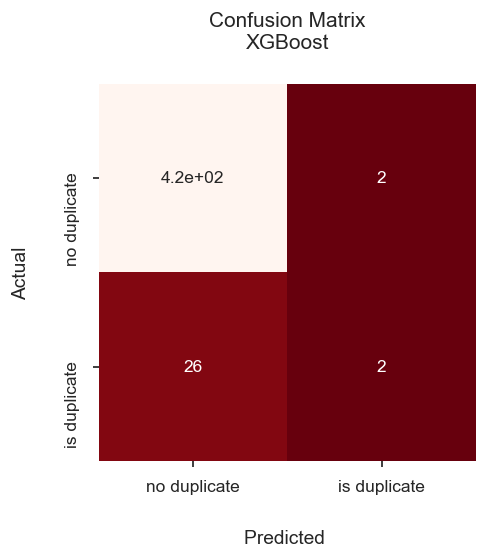

In [906]:
# # Print confusion matrix for Logistic Regression
# xgbc_confusion = confusion_matrix(y_test, clf.predict(X_test))

# plt.figure(dpi=125)
# sns.heatmap(xgbc_confusion, cmap='Reds_r', annot=True, square=True, cbar=False,
#             xticklabels=['no duplicate', 'is duplicate'],
#             yticklabels=['no duplicate', 'is duplicate'])

# plt.title('Confusion Matrix\nXGBoost', pad=20)
# plt.xlabel('Predicted ', labelpad=20)
# plt.ylabel('Actual', labelpad=20);

# Feature Engineering

In [889]:
df.head()

,case_id,opened,closed,updated,status_notes,responsible_agency,category,request_type,request_details,address,street,supervisor_district,neighborhood,police_district,latitude,longitude,point,source,is_duplicate
7182,11879660,2019-12-30 23:38:00,2020-01-04 14:12:01,2020-01-04 14:12:01,Case Transferred - Should be routed to 311 Call Center,DPW Ops Queue,Tree Maintenance,Trees - Overgrown_Tree,Pruning_request,"43 CHENERY ST, SAN FRANCISCO, CA, 94131",CHENERY ST,8,Fairmount,INGLESIDE,37.74109,-122.42565,"(37.74109, -122.42565)",Mobile/Open311,False
7183,11879654,2019-12-30 23:36:00,2019-12-31 14:06:24,2019-12-31 14:06:24,Case Resolved - SES Graffiti Crew - Scrape - Pole - Sign (Comment),DPW Ops Queue,Illegal Postings,Illegal Postings - Affixed_Improperly,Affixed Improperly,"5828 GEARY BLVD, SAN FRANCISCO, CA, 94121",GEARY BLVD,1,Outer Richmond,RICHMOND,37.78036,-122.48195,"(37.78036333, -122.481955)",Mobile/Open311,False
7184,11879642,2019-12-30 23:30:00,2020-01-03 10:14:44,2020-01-03 10:14:44,Encampment Removed,HSOC Queue,General Request - PUBLIC WORKS,request_for_service,bsm - request_for_service,"49 ISIS ST, SAN FRANCISCO, CA, 94103",ISIS ST,6,South of Market,SOUTHERN,37.77003,-122.41459,"(37.77003037, -122.41458782)",Web,False
7185,11879593,2019-12-30 22:48:00,2020-01-03 09:54:29,2020-01-03 09:54:29,Encampment Removed,Duplicate Case Hold Queue,Encampments,Encampment Reports,Encampment Cleanup,"3515 16TH ST, SAN FRANCISCO, CA, 94114",16TH ST,8,Castro,MISSION,37.76424,-122.43125,"(37.7642427, -122.43125)",Web,False
7186,11879571,2019-12-30 22:19:33,2020-01-03 00:00:00,2020-01-03 00:00:00,Case Resolved - Abated Tags,DPW Ops Queue,Graffiti,Graffiti on Fire_Police_Callbox,Fire_Police_Callbox - Not_Offensive,Intersection of POST ST and TAYLOR ST,POST ST,3,Lower Nob Hill,CENTRAL,37.78789,-122.41171,"(37.78788736, -122.41170562)",Mobile/Open311,False


* Cosine similarity of service_subtype
* Time of day (hourly, bins)
* Day of the week
* Date
* Block type / building permit
* Lat/long rounded to 3rd decimal place
* Zip code
* Duplication ratio by category or something similar
* 